# 📊 Supporter Retention Analysis with Retentioneering

Simple demonstration of calculating 6-month retention using native retentioneering data processors.

---

## Setup

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

import retentioneering
from retentioneering.eventstream import Eventstream, EventstreamSchema

print(f"Retentioneering version: {retentioneering.__version__}")

Retentioneering version: 3.3.0


In [2]:
# Import our retention processor
import sys
sys.path.append('../')

from src.retention_metrics.six_month_retention_processor import SixMonthRetentionProcessor

print("SixMonthRetentionProcessor imported successfully!")

SixMonthRetentionProcessor imported successfully!


## Generate Demo Data

In [3]:
USE_SQL_DATA = True

if USE_SQL_DATA:
    # Load data from SQL database
    from src.data.extraction import DataExtractor
    extractor = DataExtractor()
    supporter_data = extractor.extract_supporter_actions(
        start_date='2023-01-01',
        end_date='2024-12-31',
        use_cache=True
    )

else:
    # Generate synthetic supporter data
    np.random.seed(42)

    action_types = ['donation', 'petition_signed', 'event_attended', 'newsletter_signup', 'volunteer_signup']
    excluded_statuses = ['is_regular_giver', 'is_mid_value_donor']  # Status attributes to filter out

    data = []
    start_date = datetime(2023, 1, 1)

    for supporter_id in range(1, 201):  # 200 supporters
        n_actions = np.random.poisson(4) + 1
        supporter_start = start_date + timedelta(days=np.random.randint(0, 365))
        
        for action_num in range(n_actions):
            days_offset = np.random.exponential(30) * action_num
            action_date = supporter_start + timedelta(days=int(days_offset))
            
            # Mix of real actions and status attributes
            if np.random.random() < 0.1:
                action_type = np.random.choice(excluded_statuses)
            else:
                action_type = np.random.choice(action_types)
            
            data.append({
                'supporter_id': f'supporter_{supporter_id:03d}',
                'action_type': action_type,
                'action_date': action_date
            })

    supporter_data = pd.DataFrame(data)

print(f"Generated {len(supporter_data)} actions for {supporter_data['supporter_id'].nunique()} supporters")
supporter_data.head()

2025-07-14 13:25:44,473 - src.config.settings - INFO - __init__:130 - Configuration loaded for environment: development
2025-07-14 13:25:44,474 - src.config.settings - INFO - __init__:131 - Debug mode: True
2025-07-14 13:25:44,474 - src.config.settings - INFO - __init__:132 - Development mode: True
2025-07-14 13:25:44,476 - src.data.extraction - INFO - __init__:43 - DataExtractor initialized
2025-07-14 13:25:44,571 - src.data.extraction - DEBUG - _load_from_cache:508 - Loaded data from cache: data/raw/actions_2023-01-01_2024-12-31_none_none.pkl
2025-07-14 13:25:44,571 - src.data.extraction - INFO - extract_supporter_actions:77 - Loaded supporter actions from cache: actions_2023-01-01_2024-12-31_none_none


Generated 630628 actions for 347613 supporters


,supporter_id,action_date,action_type,tags,supporter_level
0,1140218,2023-01-27 03:48:06,VOL,A-VOL_EOI-Z-Z-,1
1,1553597,2023-03-16 03:39:47,VOL,A-VOL_EOI-Z-Z-,1
2,1561805,2023-04-10 23:08:41,VOL,A-VOL_EOI-Z-Z-,1
3,1578338,2023-07-05 06:48:11,VOL,A-VOL_EOI-Z-Z-,1
4,1590656,2023-07-05 07:01:42,VOL,A-VOL_EOI-Z-Z-,1


## Create Eventstream

In [4]:
# Create retentioneering Eventstream
raw_data_schema = {
    'user_id': 'supporter_id',
    'event_name': 'action_type',
    'event_timestamp': 'action_date'
}

# schema = EventstreamSchema(
#     user_id='supporter_id',
#     event_type='action_type',
#     event_timestamp='action_date'
# )

eventstream = Eventstream(supporter_data, raw_data_schema=raw_data_schema, add_start_end_events=False)
print(f"Eventstream created: {len(eventstream.to_dataframe())} events")

# Quick description
eventstream.describe()

2025-07-14 13:25:44,683 - urllib3.connectionpool - DEBUG - _new_conn:1049 - Starting new HTTPS connection (2): ftrack-1.server.retentioneering.com:443
2025-07-14 13:25:44,854 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0
2025-07-14 13:25:45,609 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0
2025-07-14 13:25:47,269 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0
2025-07-14 13:25:47,270 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0
2025-07-14 13:25:47,424 - urllib3.connectionpool - DEBUG - _new_conn:1049 - Starting new HTTPS connection (3): ftrack-1.server.retentioneering.com:443
2025-07-14 13:25:47,425 - urllib3.conn

Eventstream created: 630628 events


value
category          metric                                 
overall           unique_users                     347613
                  unique_events                        15
                  eventstream_start   2023-01-01 00:01:02
                  eventstream_end     2024-12-30 23:42:11
                  eventstream_length    729 days 23:41:09
path_length_time  mean                   46 days 13:35:13
                  std                   133 days 04:48:31
                  median                  0 days 00:00:00
                  min                     0 days 00:00:00
                  max                   728 days 03:41:54
path_length_steps mean                               1.81
                  std                                3.05
                  median                              1.0
                  min                                   1
                  max                                 109

## Calculate 6-Month Retention

In [5]:
# Initialize processor
processor = SixMonthRetentionProcessor(eventstream)

# Define analysis periods
analysis_date = datetime(2024, 1, 1)
last_period_start = analysis_date - timedelta(days=180)
last_period_end = analysis_date
following_period_start = analysis_date
following_period_end = analysis_date + timedelta(days=180)

print(f"Last period: {last_period_start.date()} to {last_period_end.date()}")
print(f"Following period: {following_period_start.date()} to {following_period_end.date()}")

# Calculate retention
result = processor.calculate_metric_1(
    last_period_start=last_period_start,
    last_period_end=last_period_end,
    following_period_start=following_period_start,
    following_period_end=following_period_end
)

print("\n" + "="*40)
print("6-MONTH RETENTION RESULTS")
print("="*40)
print(f"Retention Rate: {result['retention_rate']:.1f}%")
print(f"Supporters Retained: {result['supporters_retained']}")
print(f"Supporters Not Retained: {result['supporters_not_retained']}")
print(f"Total Supporters: {result['total_supporters_last_period']}")

2025-07-14 13:25:47,822 - src.retention_metrics.six_month_retention_processor - INFO - calculate_metric_1:62 - Starting 6-month retention calculation
2025-07-14 13:25:47,823 - src.retention_metrics.six_month_retention_processor - DEBUG - _filter_eventstream_for_analysis:134 - Filtering eventstream for analysis period
2025-07-14 13:25:47,825 - urllib3.connectionpool - DEBUG - _new_conn:1049 - Starting new HTTPS connection (11): ftrack-1.server.retentioneering.com:443
2025-07-14 13:25:47,914 - urllib3.connectionpool - DEBUG - _new_conn:1049 - Starting new HTTPS connection (12): ftrack-1.server.retentioneering.com:443
2025-07-14 13:25:47,915 - urllib3.connectionpool - DEBUG - _new_conn:1049 - Starting new HTTPS connection (13): ftrack-1.server.retentioneering.com:443
2025-07-14 13:25:47,933 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0


Last period: 2023-07-05 to 2024-01-01
Following period: 2024-01-01 to 2024-06-29


2025-07-14 13:25:48,067 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0
2025-07-14 13:25:48,201 - src.retention_metrics.six_month_retention_processor - DEBUG - _filter_eventstream_for_analysis:159 - Filtered to 399475 events from 257614 supporters
2025-07-14 13:25:48,220 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0
2025-07-14 13:25:48,227 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0
2025-07-14 13:25:48,312 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0
2025-07-14 13:25:48,314 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0


6-MONTH RETENTION RESULTS
Retention Rate: 11.2%
Supporters Retained: 21709
Supporters Not Retained: 172487
Total Supporters: 194196


## Visualize with Retentioneering

In [6]:
# Get labeled eventstream (with positive_target and negative_target events)
labeled_stream = result['eventstream_with_labels']

# Add boundaries for visualization
# viz_stream = labeled_stream.add_start_end_events()
viz_stream = labeled_stream

print("Creating transition graph with retention labels...")

# Create transition graph
transition_graph = viz_stream.transition_graph(
    width=1000,
    height=600
)

transition_graph

2025-07-14 13:25:53,845 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0


Creating transition graph with retention labels...


2025-07-14 13:25:53,891 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0
2025-07-14 13:25:53,923 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0
2025-07-14 13:25:53,945 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0
2025-07-14 13:25:53,946 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0
2025-07-14 13:25:53,956 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0
2025-07-14 13:25:53,956 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0
2025-07-14

Creating step matrix...


2025-07-14 13:26:20,874 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0
2025-07-14 13:26:20,874 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0
2025-07-14 13:26:20,874 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0
2025-07-14 13:26:20,874 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0
2025-07-14 13:26:20,882 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0
2025-07-14 13:26:20,882 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0
2025-07-14

2025-07-14 13:26:21,753 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0
2025-07-14 13:26:21,768 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0
2025-07-14 13:26:21,776 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0
2025-07-14 13:26:21,777 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0


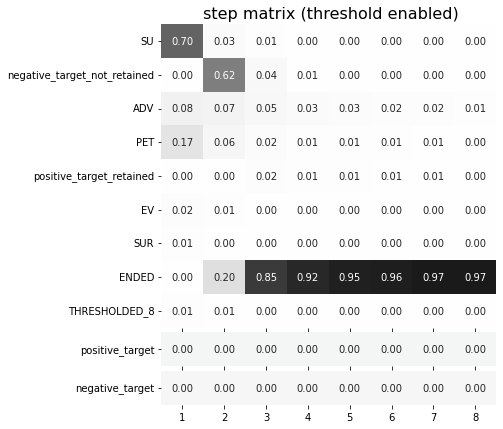

2025-07-14 13:26:21,917 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0
2025-07-14 13:26:21,920 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0


In [ ]:
# Create step matrix
print("Creating step matrix...")

step_matrix = viz_stream.step_matrix(
    max_steps=8,
    targets=['positive_target', 'negative_target']
)

step_matrix

2025-07-14 13:25:56,973 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0
2025-07-14 13:25:56,974 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0


Creating cohort analysis...


2025-07-14 13:25:57,156 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0
2025-07-14 13:25:57,161 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0
2025-07-14 13:25:57,161 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0
2025-07-14 13:25:57,166 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0
2025-07-14 13:25:57,169 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0
2025-07-14 13:25:57,169 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0
2025-07-14

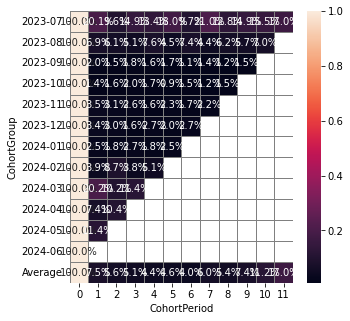

In [8]:
# Create cohort analysis
print("Creating cohort analysis...")

cohorts = viz_stream.cohorts(
    cohort_start_unit='M',
    cohort_period=(1, 'M')
)

cohorts

## Simple Results Summary

In [ ]:
# Display summary
print("RETENTION ANALYSIS SUMMARY")
print("="*30)
print(f"Analysis Date: {analysis_date.date()}")
print(f"Retention Rate: {result['retention_rate']:.1f}%")
print(f"Total Supporters Analyzed: {result['total_supporters_last_period']}")
print(f"Retained: {result['supporters_retained']}")
print(f"Not Retained: {result['supporters_not_retained']}")

# Performance assessment
if result['retention_rate'] >= 60:
    print("\n✅ Good retention rate!")
else:
    print("\n⚠️ Retention rate could be improved")

print("\nNext steps:")
print("- Analyze supporter behavior patterns")
print("- Implement targeted engagement campaigns")
print("- Monitor retention trends monthly")

RETENTION ANALYSIS SUMMARY
Analysis Date: 2024-01-01
Retention Rate: 11.2%
Total Supporters Analyzed: 194196
Retained: 21709
Not Retained: 172487

⚠️ Retention rate could be improved

Next steps:
- Analyze supporter behavior patterns
- Implement targeted engagement campaigns
- Monitor retention trends monthly


2025-07-14 13:25:57,488 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0
2025-07-14 13:25:57,490 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0
2025-07-14 13:25:57,496 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0
2025-07-14 13:25:57,563 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0
2025-07-14 13:25:57,564 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0
2025-07-14 13:25:57,568 - urllib3.connectionpool - DEBUG - _make_request:544 - https://ftrack-1.server.retentioneering.com:443 "POST /endpoint/event HTTP/1.1" 204 0
